## Example for computing parallel imaging g-factor using BART Python interface

Author: Jon Tamir <jtamir@eecs.berkeley.edu>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import sys
import os.path

import cfl
from bart import bart

from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

## Create multi-channel phantom in k-space

In [2]:
nx = 128
ny = 128
nc = 5

rx = 2
ry = 2

n_mc = 100


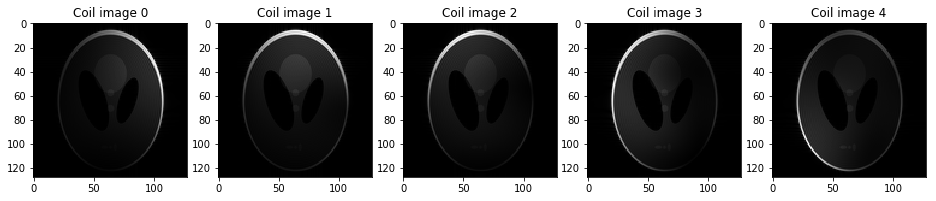

In [3]:
ksp = bart(1, 'phantom -x {} -s {} -k'.format(nx, nc))
cimg = bart(1, 'fft -iu 3', ksp)
rimg = bart(1, 'rss 8', cimg)

plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(cimg[:,:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil image {}'.format(i))

## Estimate coil sensitivities

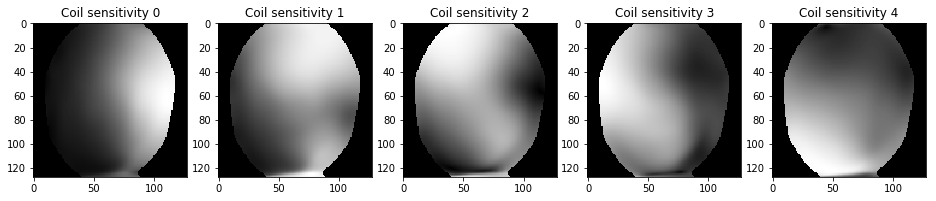

In [4]:
sens = bart(1, 'ecalib -m1', ksp)

plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(sens[:,:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil sensitivity {}'.format(i))

## Create sampling patterns

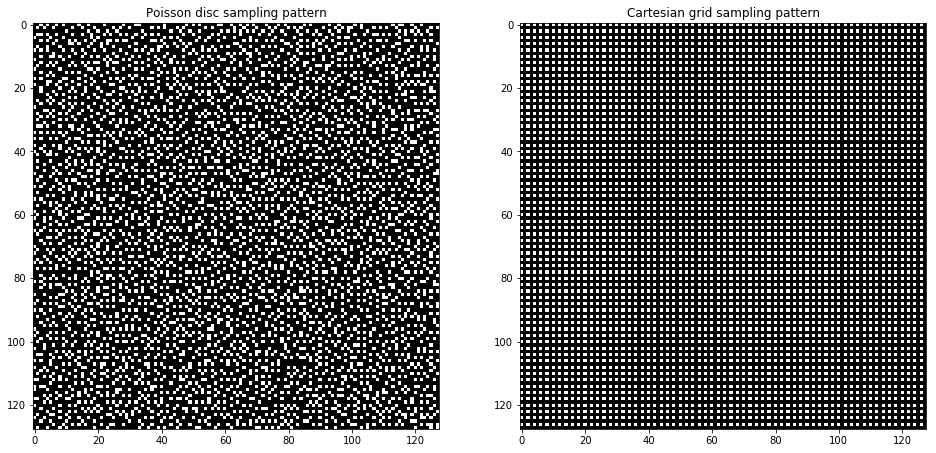

In [5]:
mask_pd = bart(1, 'poisson -Y {} -Z {} -y {} -z {}'.format(nx, ny, rx, ry)).squeeze() != 0
mask_cg = np.zeros((nx, ny))
mask_cg[::rx,::ry] = 1

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(mask_pd, cmap='gray')
plt.title('Poisson disc sampling pattern')
plt.subplot(1, 2, 2)
plt.imshow(mask_cg, cmap='gray')
plt.title('Cartesian grid sampling pattern')

## apply masks and reconstruct

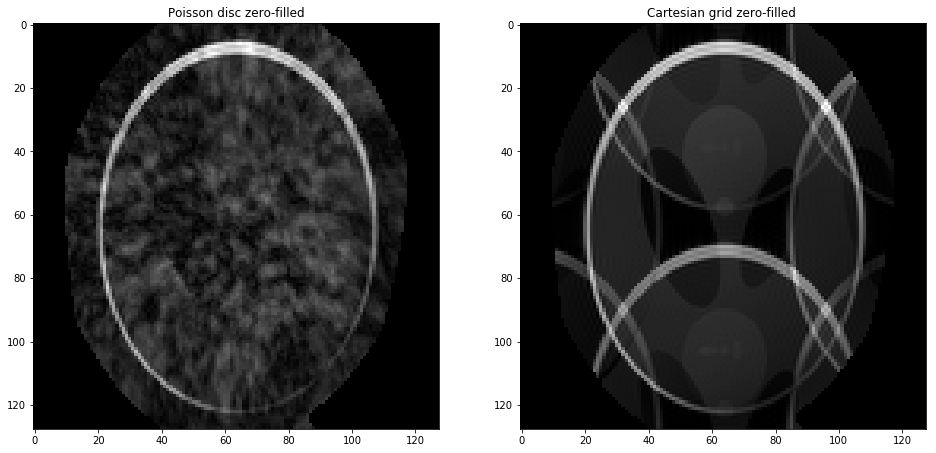

In [6]:
ksp_cg = bart(1, 'fmac', ksp, mask_cg)
ksp_pd = bart(1, 'fmac', ksp, mask_pd)

reco_pd_zfill = np.sum(bart(1, 'fft -iu 3', ksp_pd) * np.conj(sens), axis=3)
reco_cg_zfill = np.sum(bart(1, 'fft -iu 3', ksp_cg) * np.conj(sens), axis=3)


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(abs(reco_pd_zfill).squeeze(), cmap='gray')
plt.title('Poisson disc zero-filled')

plt.subplot(1, 2, 2)
plt.imshow(abs(reco_cg_zfill).squeeze(), cmap='gray')
plt.title('Cartesian grid zero-filled ')


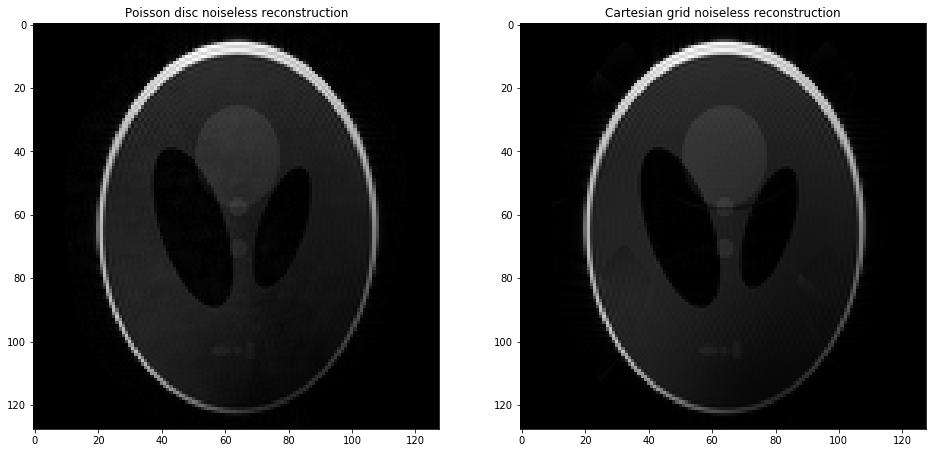

In [7]:
reco_cg_clean = bart(1, 'pics', ksp_cg, sens)
reco_pd_clean = bart(1, 'pics', ksp_pd, sens)


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(abs(reco_pd_clean).squeeze(), cmap='gray')
plt.title('Poisson disc noiseless reconstruction')

plt.subplot(1, 2, 2)
plt.imshow(abs(reco_cg_clean).squeeze(), cmap='gray')
plt.title('Cartesian grid noiseless reconstruction')

## add noise and repeat reconstruction

In [8]:
recons_cg = np.zeros((nx, ny, n_mc), dtype=np.complex)
recons_pd = np.zeros((nx, ny, n_mc), dtype=np.complex)

tic = time.time()
for i in range(n_mc):
    ksp_noise = bart(1, 'noise -n 1 -s {}'.format(i), ksp)
    
    ksp_cg_noise = bart(1, 'fmac', ksp_noise, mask_cg)
    ksp_pd_noise = bart(1, 'fmac', ksp_noise, mask_pd)
    
    recons_cg[:,:,i] = bart(1, 'pics', ksp_cg_noise, sens)
    recons_pd[:,:,i] = bart(1, 'pics', ksp_pd_noise, sens)
    
toc = time.time()

print('Done ({} s)'.format(toc - tic))

Done (46.259998083114624 s)


## compute g-factor

Max PD g-factor value: 0.6694895423124833
Max CG g-factor value: 11.250969402388709


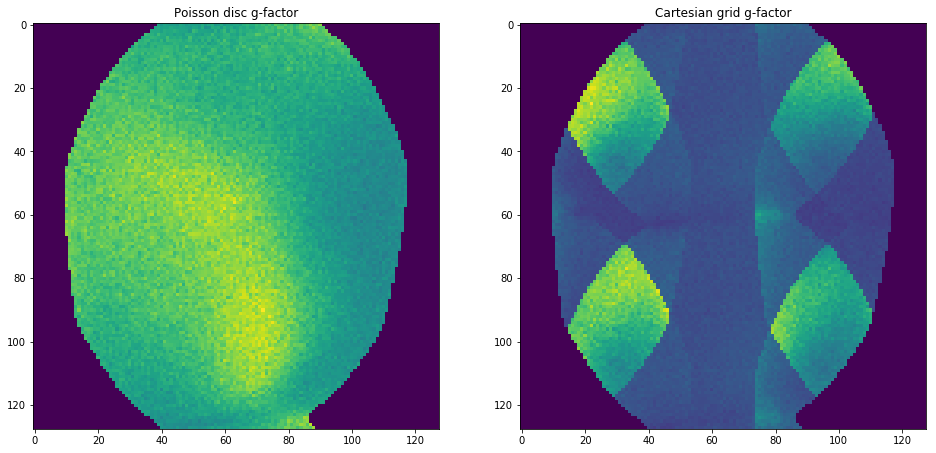

In [9]:
reco_diff_cg = recons_cg - reco_cg_clean[:, :, None]
gfactor_cg = np.std(reco_diff_cg, axis=2)

reco_diff_pd = recons_pd - reco_pd_clean[:, :, None]
gfactor_pd = np.std(reco_diff_pd, axis=2)


print('Max PD g-factor value: {}'.format(np.max(gfactor_pd)))
print('Max CG g-factor value: {}'.format(np.max(gfactor_cg)))


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(gfactor_pd)
plt.title('Poisson disc g-factor')

plt.subplot(1, 2, 2)
plt.imshow(gfactor_cg)
plt.title('Cartesian grid g-factor')